In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib import cm

In [14]:
path="/lustre/ytzheng/"

Casename = 'ASTEX_warm2.6'
Casename1 = 'ASTEX_warm5.2'
Casename2 = 'ASTEX_warm2.6_Div3'

f = xr.open_mfdataset(path + Casename + '/' + '*N100.nc',
                      combine = 'by_coords',decode_cf = False)
f1 = xr.open_mfdataset(path + Casename1 + '/' + '*N100.nc',
                      combine = 'by_coords',decode_cf = False)
f2 = xr.open_mfdataset(path + Casename2 + '/' + '*N100.nc',
                      combine = 'by_coords',decode_cf = False)

In [15]:
# f = f.isel(time = slice(0,31))
# f1 = f1.isel(time = slice(0,31))
# f2 = f2.isel(time = slice(0,31))

f = f.isel(time = slice(0,60))
f1 = f1.isel(time = slice(0,60))
f2 = f2.isel(time = slice(0,60))

nt = f['time'].size
t_hours = np.arange(nt)

z = f['z']/1000.

myfontsize = 12

In [16]:
def plt1D(ax, x, y, y1, y2, ytitle, smooth=0
         ,xlabel = 1, xrange = [0, 30]):
    if smooth == 0:
        ax.plot(x, y, linewidth=2, label = 'wadv', color = 'crimson')
        ax.plot(x, y1, linewidth=2, label = 'wadv5.2', linestyle = '-',color = 'forestgreen')
        ax.plot(x, y2, linewidth=2, label = 'wadv Div3', linestyle = '-',color = 'orange')
    else:
        ax.plot(x, y, linewidth=2, color = 'crimson', alpha=0.2)
        ax.plot(x, y1, linewidth=2, linestyle = '-',color = 'forestgreen', alpha=0.2)
        ax.plot(x, y2, linewidth=2, linestyle = '-',color = 'orange', alpha=0.2)
        
        yhat = savgol_filter(y, 15, 3)
        yhat1 = savgol_filter(y1, 15, 3)
        yhat2 = savgol_filter(y2, 15, 3)
        
        ax.plot(x, yhat, linewidth=2, label = 'wadv', color = 'crimson')
        ax.plot(x, yhat1, linewidth=2, label = 'wadv5.2', linestyle = '-',color = 'forestgreen')
        ax.plot(x, yhat2, linewidth=2, label = 'wadv Div3', linestyle = '-',color = 'orange')
        
    ax.grid(True)
    ax.set_xlim(xrange)
    ax.set_ylabel(ytitle, fontsize=myfontsize)  # Add a y-label to the axes.
    if xlabel != 0:
        ax.set_xlabel('Time (hours)', fontsize=myfontsize)  # Add a y-label to the axes.

In [17]:
#determine top of surface inversion
indtmp = f.THL2.where(f.z < 0.5*1000.*f.ZINV).argmax(dim = 'z', skipna = 'True')
zinv_bot = f.z[indtmp]/1000.
qtflx_up = f.QTFLUX.sel(z = 1000.*zinv_bot, method="nearest")
qtflx_bot = f.QTFLUX.sel(z = f.z[0], method="nearest")

indtmp = f1.THL2.where(f1.z < 0.5*1000.*f1.ZINV).argmax(dim = 'z', skipna = 'True')
zinv_bot1 = f1.z[indtmp]/1000.
qtflx_up1 = f1.QTFLUX.sel(z = 1000.*zinv_bot1, method="nearest")
qtflx_bot1 = f1.QTFLUX.sel(z = f.z[0], method="nearest")

indtmp = f2.THL2.where(f2.z < 0.5*1000.*f2.ZINV).argmax(dim = 'z', skipna = 'True')
zinv_bot2 = f2.z[indtmp]/1000.
qtflx_up2 = f2.QTFLUX.sel(z = 1000.*zinv_bot2, method="nearest")
qtflx_bot2 = f2.QTFLUX.sel(z = f.z[0], method="nearest")

In [18]:
from sam_sat import *
qsat = qsatw(f.SST,f.Ps)
qsat1 = qsatw(f1.SST,f1.Ps)
qsat2 = qsatw(f2.SST,f2.Ps)

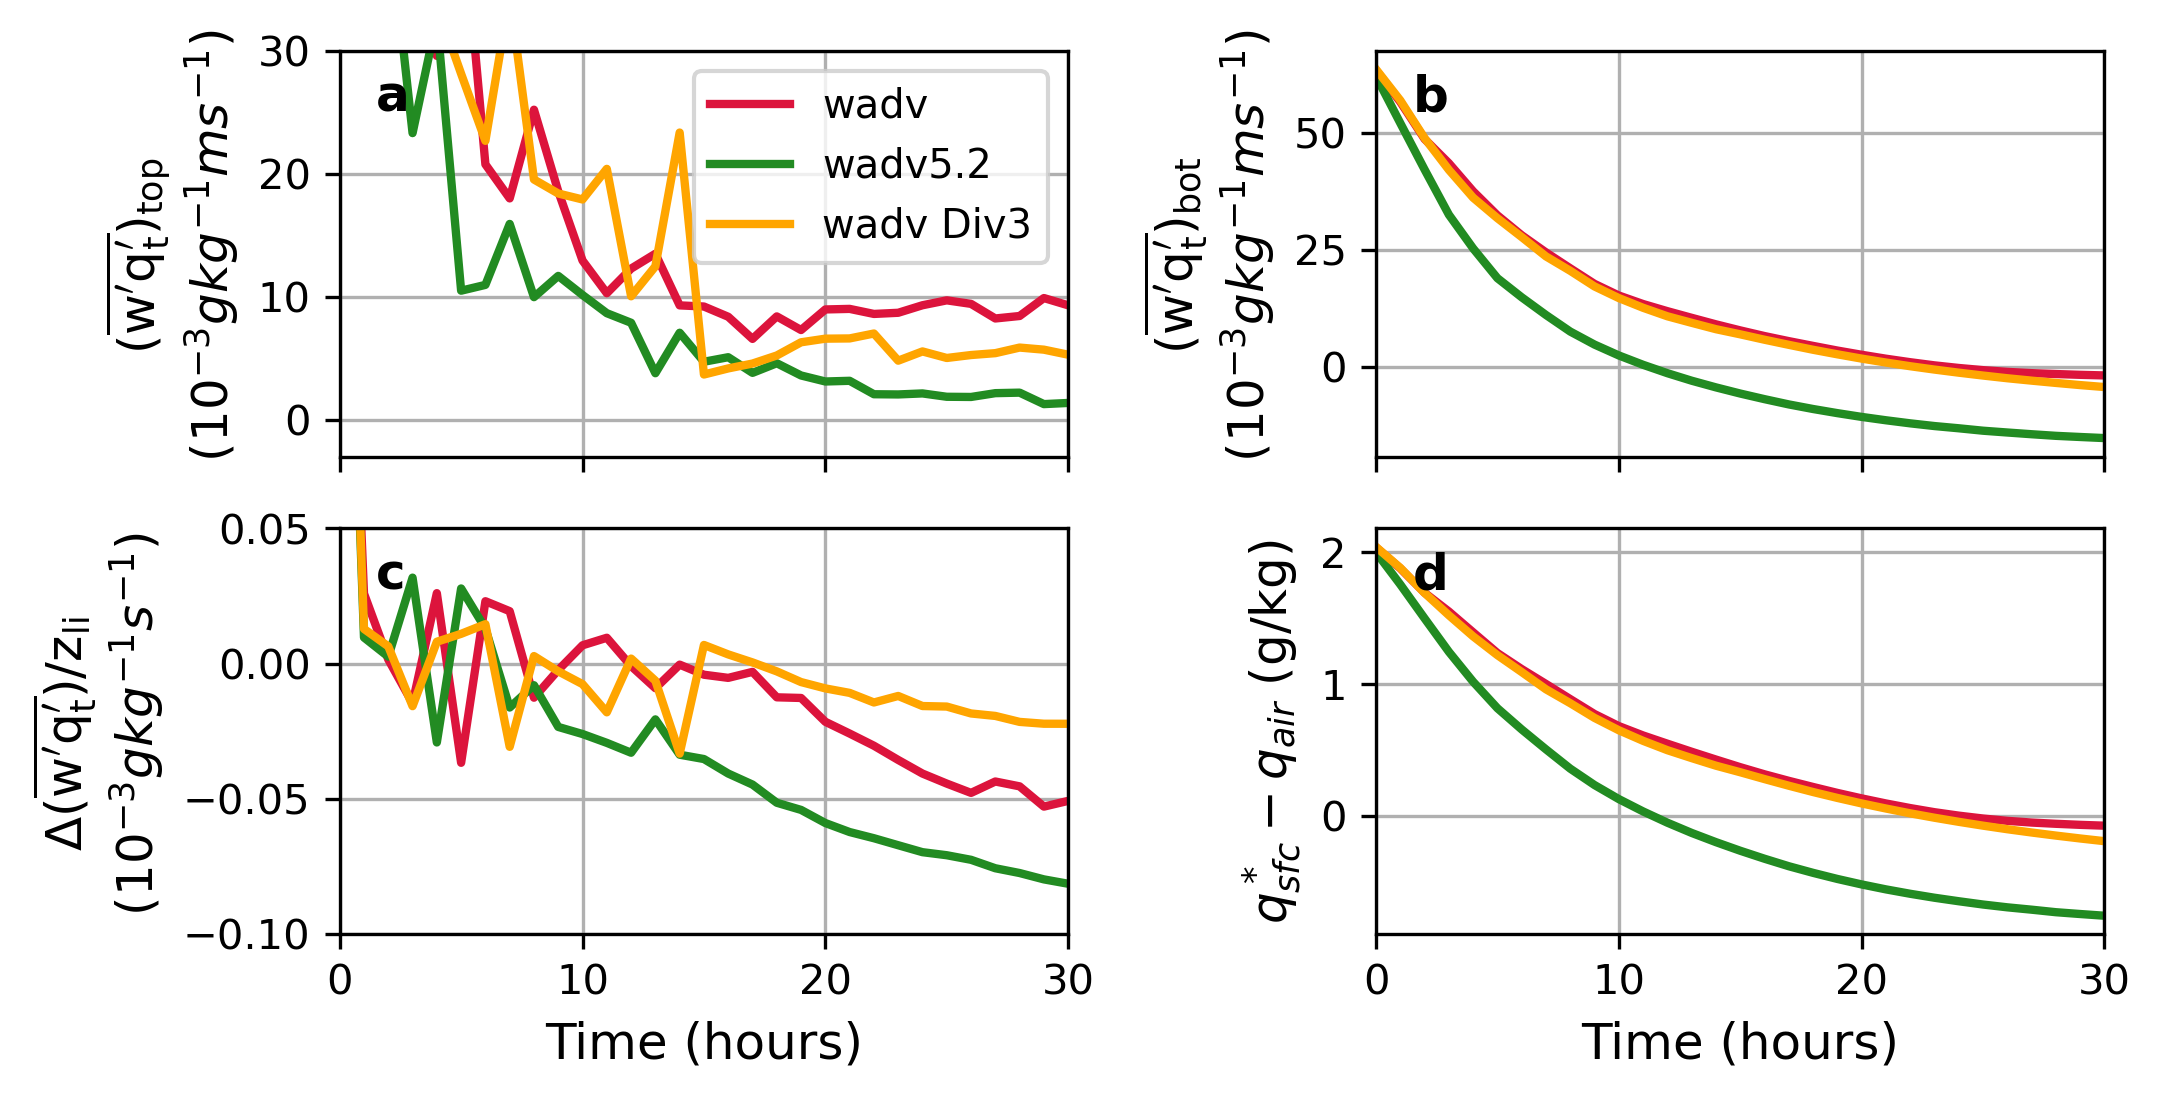

In [9]:
fig, axs = plt.subplots(ncols = 2,
                        nrows = 2,
                        sharex = True, sharey = False,
                        figsize=(18/2.54, (9)/2.54), dpi = 300, constrained_layout=True)

# plt.tight_layout()

plt1D(axs[0,0], t_hours, qtflx_up, qtflx_up1, qtflx_up2,
      "$\mathrm{(\overline{w^{\prime}q_t^{\prime}})_{top}}$ \n $(10^{-3}gkg^{-1}ms^{-1})$", xlabel = 0)
axs[0,0].legend(loc="best", fontsize=0.8*myfontsize)

axs[0,0].set_ylim([-3, 30])

plt1D(axs[0,1], t_hours, qtflx_bot, qtflx_bot1, qtflx_bot2,
      "$\mathrm{(\overline{w^{\prime}q_t^{\prime}})_{bot}}$ \n $(10^{-3}gkg^{-1}ms^{-1})$", xlabel = 0)

plt1D(axs[1,0], t_hours, (qtflx_bot - qtflx_up)/(1000.*zinv_bot), 
      (qtflx_bot1 - qtflx_up1)/(1000.*zinv_bot1),
      (qtflx_bot2 - qtflx_up2)/(1000.*zinv_bot2),
      "$\mathrm{\Delta(\overline{w^{\prime}q_t^{\prime}})/z_{li}}$ \n $(10^{-3}gkg^{-1}s^{-1})$", xlabel = 1)

axs[1,0].set_ylim([-0.1, 0.05])

plt1D(axs[1,1], t_hours, 1000.*qsat - f['QT'].isel(z=0), 1000.*qsat1 - f1['QT'].isel(z=0), 1000.*qsat2 - f2['QT'].isel(z=0),
      "$q_{sfc}^* - q_{air}$ (g/kg)", xlabel = 1)

mylabel = np.array((['a','b'],['c','d']))

for i in range(2):
    for j in range (2):
        axs[i,j].text(0.05, 0.85, mylabel[i,j], 
                      transform=axs[i,j].transAxes,fontsize=myfontsize, fontweight='bold')

fig.savefig('plot_result3_time_series.png', dpi=fig.dpi, bbox_inches='tight')

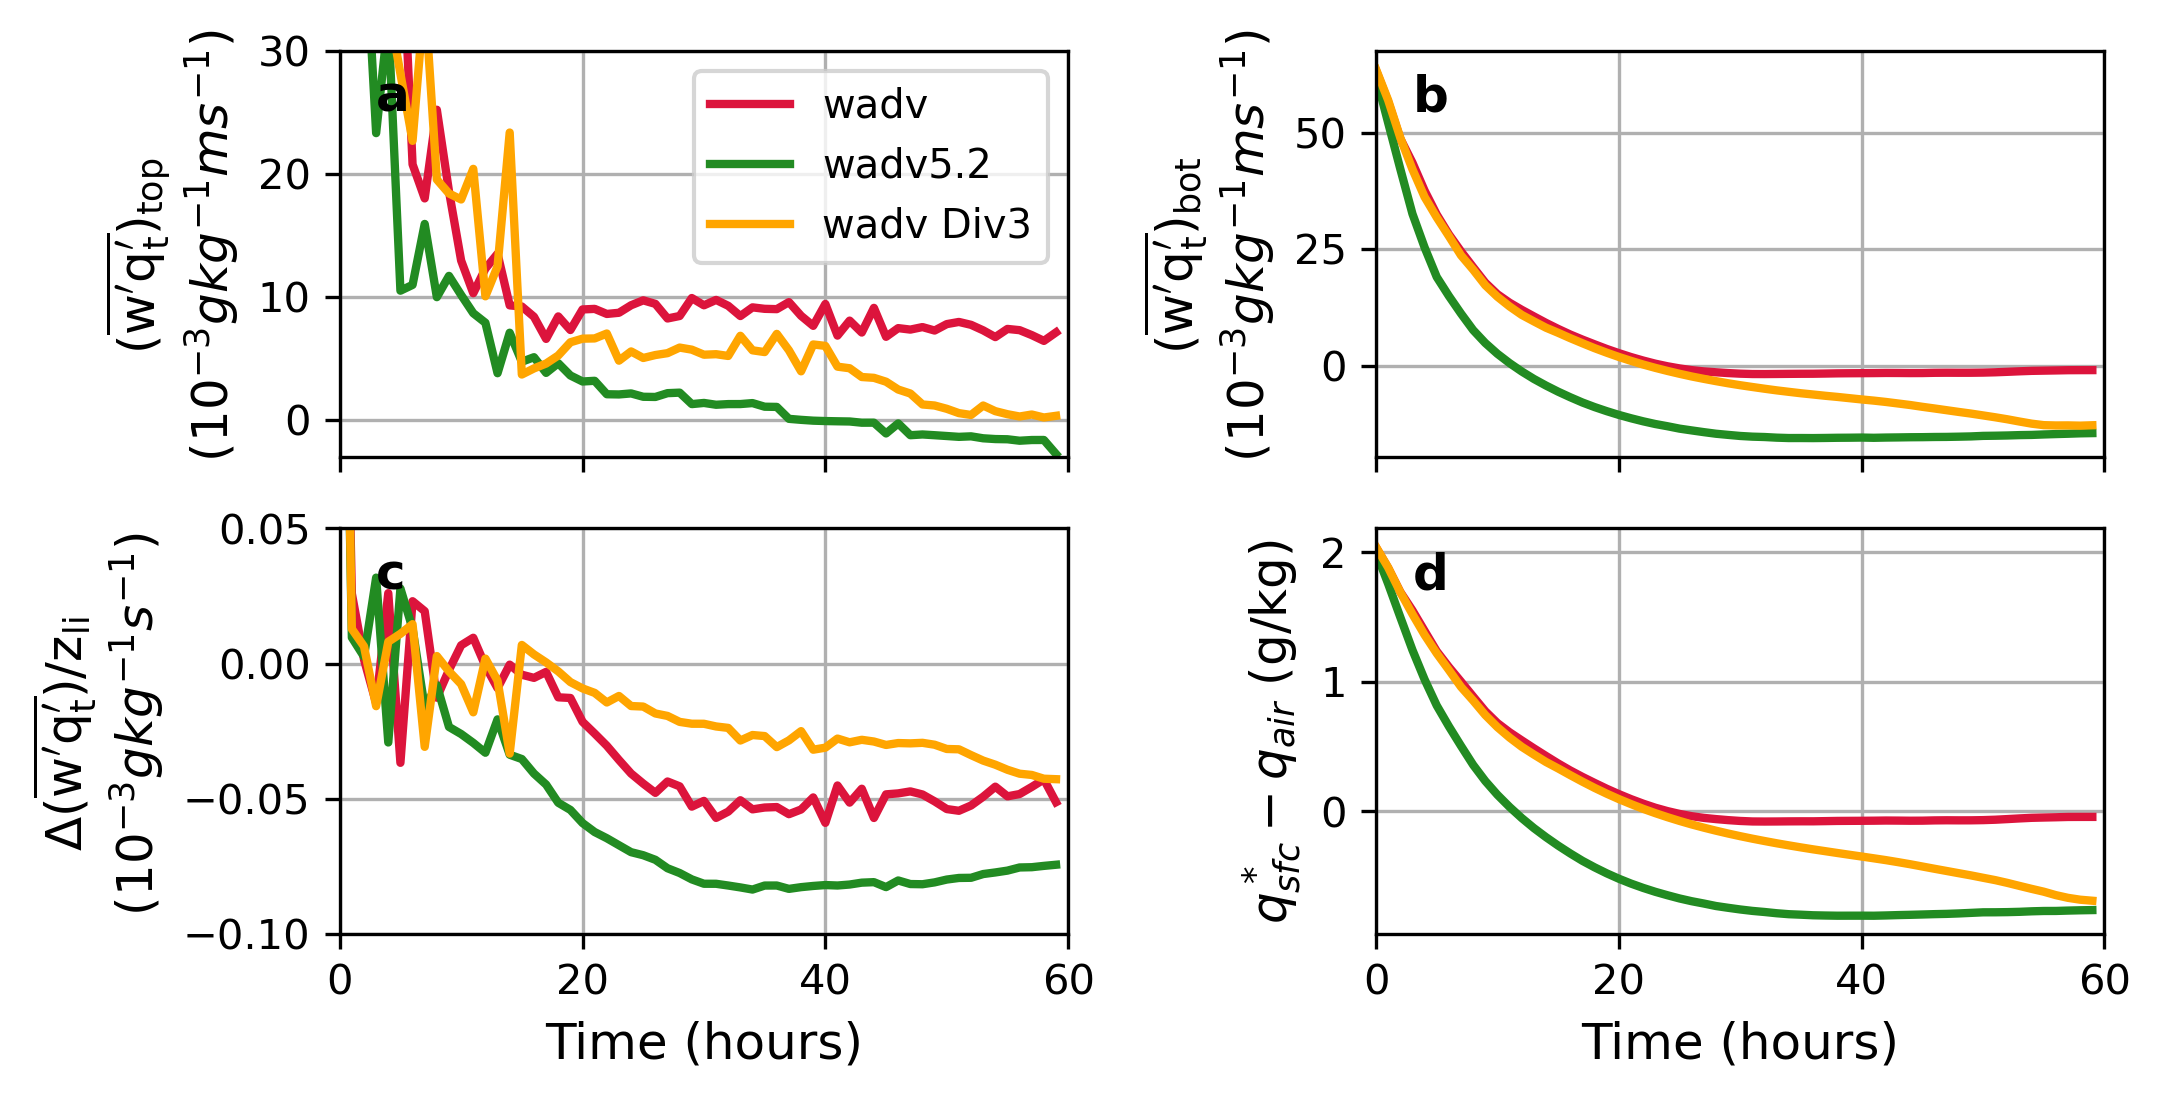

In [20]:
fig, axs = plt.subplots(ncols = 2,
                        nrows = 2,
                        sharex = True, sharey = False,
                        figsize=(18/2.54, (9)/2.54), dpi = 300, constrained_layout=True)

# plt.tight_layout()

plt1D(axs[0,0], t_hours, qtflx_up, qtflx_up1, qtflx_up2,
      "$\mathrm{(\overline{w^{\prime}q_t^{\prime}})_{top}}$ \n $(10^{-3}gkg^{-1}ms^{-1})$", xlabel = 0, xrange = [0, 60])
axs[0,0].legend(loc="best", fontsize=0.8*myfontsize)

axs[0,0].set_ylim([-3, 30])

plt1D(axs[0,1], t_hours, qtflx_bot, qtflx_bot1, qtflx_bot2,
      "$\mathrm{(\overline{w^{\prime}q_t^{\prime}})_{bot}}$ \n $(10^{-3}gkg^{-1}ms^{-1})$", xlabel = 0,xrange = [0, 60])

plt1D(axs[1,0], t_hours, (qtflx_bot - qtflx_up)/(1000.*zinv_bot), 
      (qtflx_bot1 - qtflx_up1)/(1000.*zinv_bot1),
      (qtflx_bot2 - qtflx_up2)/(1000.*zinv_bot2),
      "$\mathrm{\Delta(\overline{w^{\prime}q_t^{\prime}})/z_{li}}$ \n $(10^{-3}gkg^{-1}s^{-1})$", xlabel = 1,xrange = [0, 60])

axs[1,0].set_ylim([-0.1, 0.05])

plt1D(axs[1,1], t_hours, 1000.*qsat - f['QT'].isel(z=0), 1000.*qsat1 - f1['QT'].isel(z=0), 1000.*qsat2 - f2['QT'].isel(z=0),
      "$q_{sfc}^* - q_{air}$ (g/kg)", xlabel = 1,xrange = [0, 60])

mylabel = np.array((['a','b'],['c','d']))

for i in range(2):
    for j in range (2):
        axs[i,j].text(0.05, 0.85, mylabel[i,j], 
                      transform=axs[i,j].transAxes,fontsize=myfontsize, fontweight='bold')

fig.savefig('plot_result3_time_series_60h.png', dpi=fig.dpi, bbox_inches='tight')